# This script contains code to plot SI figure S2-S6
### Created by Alon Bar at Uri Alon's Lab for system biology, Weizmann institute

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import calendar
import pickle
import os
from scipy import stats
from scipy.integrate import odeint
from matplotlib import ticker
from tqdm import tqdm_notebook as tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import circmean,circstd
from scipy.optimize import curve_fit
from scipy.stats import zscore
from sympy import *
import matplotlib.image as mpimg
from  scipy.stats import distributions
from collections import namedtuple
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import ks_2samp
from itertools import combinations, product 
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import optimize
from statsmodels.stats.multitest import fdrcorrection as FDR

pd.set_option('display.max_rows', None)

def_color=plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'size'   : 6}

month_names=[x[:3] for x in calendar.month_name[1:13]]
plt.rc('font', weight='normal')


pituitary_hormone_dic={'ACTH_ADRENOCORTICOTROPIC_HORMONE':'ACTH',
                        'TSH_THYROID_STIMULATING_HORMONE':'TSH',
                        'LH_LUTEINIZING_HORMONE':'LH',
                        'FSH_FOLLICLE_STIMULATING_HORMONE':'FSH',
                        'GROWTH_HORMONE_GH':'GH',
                        'PROLACTIN':'Prolactin'}

effector_hormone_dic={ 'CORTISOL_BLOOD':'Cortisol',
                         'CORTISOL_U_FREE_24h':'Urinary cortisol',
                         'T3_FREE':'T3-free',
                         'T4_FREE':'T4-free',
                         'ESTRADIOL_E_2':'Estradiol',
                         'TESTOSTERONE_TOTAL':'Testosterone',
                         'INSULIN_LIKE_GROWTH_FACTOR_1':'IGF1'}

residual_hormone_dic={ '17_HYDROXY_PROGESTERONE':'17OHPG',
                       'ALDOSTERONE_BLOOD'      :'ALD',
                       'ANDROSTENEDIONE'        :'AND',
                       'ANGIOTENSIN_I_CONVERTING_ENZYME':'ACE',
                       'DHEA_SULPHATE'          :'DHEA',
                       'PARATHYROID_HORMONE_PTH':'PTH',
                       'PROGESTERONE'           :'P4',
                       'T3_TOTAL'               :'T3-total',
                       'THYROGLOBULIN'          :'TGB'}

chem_dic            = {'CALCIUM_BLOOD':'Calcium',
                        'CREATININE_BLOOD':'Creatinine',
                        'Cl':'Cl',
                        'GLUCOSE_BLOOD':'Glucose',
                        'HEMOGLOBIN_A1C_CALCULATED':'HGB-A1C',
                        'HGB':'HGB',
                        'MAGNESIUM_BLOOD':'Mg',
                        'POTASSIUM':'K',
                        'SODIUM':'Na',
                        'UREA_BLOOD':'Urea'}

chem_dic1 = {'CALCIUM_BLOOD': 'Calcium',
             'CREATININE_BLOOD': 'Creatinine',
             'Cl': 'Cl',
             'GLUCOSE_BLOOD': 'Glucose',
             'HEMOGLOBIN_A1C_CALCULATED': 'HGB-A1C'}
chem_dic2 = {'HGB': 'HGB',
             'MAGNESIUM_BLOOD': 'Mg',
             'POTASSIUM': 'K',
             'SODIUM': 'Na',
             'UREA_BLOOD': 'Urea'}

In [2]:
def seasonal_time_process_all(hormone,sex,dtype='quantile'):

    file    = '../data/Clalit_seasonality_Nov19/clock.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_80.csv'
    df  = pd.read_csv(file) 
    df  = df.loc[df['type'] ==sex]
    
    df['hour'] = df['hour']+12
    df.loc[df['hour']>24,['hour']] = df.loc[df['hour']>24,['hour']] - 24
    df = df.loc[df['hour']>6]
    df = df.loc[df['hour']<19]
    df = df.loc[df['n']>30]
    
    seas_pooled_mean = []
    seas_pooled_std  = []
    seas_pooled_n    = []

    for seas in ['winter','spring','summer','fall']:
        mdf = df.loc[df.season==seas]
        seas_pooled_mean.append(np.sum(mdf['mean']*mdf['n'])/np.sum(mdf['n']))
        seas_pooled_std.append(np.sqrt(np.sum(mdf['std']**2*(mdf['n']-1))/(np.sum(mdf['n']) - len(mdf['n']))))
        seas_pooled_n.append(np.sum(mdf['n']))

    both_res = pd.DataFrame({'seasons': ['Win','Spr','Sum','Aut'],
                             'mean' : seas_pooled_mean,
                             'std'  : seas_pooled_std,
                             'n'    : seas_pooled_n})
    return both_res

def seasonal_time_process_8am(hormone,sex,dtype='quantile'):
    file    = '../data/Clalit_seasonality_Nov19/clock.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_80.csv'
    df  = pd.read_csv(file)  
    df  = df.loc[df['type'] ==sex]
    
    df['hour'] = df['hour']+12
    df.loc[df['hour']>24,['hour']] = df.loc[df['hour']>24,['hour']] - 24
    df = df.loc[df['n']>30]
    
    df  = df.loc[df['hour'] == 8]
    seas_pooled_mean = []
    seas_pooled_std  = []
    seas_pooled_n    = []
    for seas in ['winter','spring','summer','fall']:
        mdf = df.loc[df.season==seas]
        seas_pooled_mean.append(np.sum(mdf['mean']*mdf['n'])/np.sum(mdf['n']))
        seas_pooled_std.append(np.sqrt(np.sum(mdf['std']**2*(mdf['n']-1))/(np.sum(mdf['n']) - len(mdf['n']))))
        seas_pooled_n.append(np.sum(mdf['n']))

    both_res = pd.DataFrame({'seasons': ['Win','Spr','Sum','Aut'],
                             'mean' : seas_pooled_mean,
                             'std'  : seas_pooled_std,
                             'n'    : seas_pooled_n})
    return both_res

def seasonal_time_process_sunrise_phase(hormone,sex,dtype='quantile'):
    ## winter sunrise at 6:35       - use 9AM
    ## spring sunrise at 5:40/6:30  - use 8AM,9AM
    ## summer sunrise at 5:34       - use 8AM
    ## fall sunrise at 6:26/5:50    - use 8AM,9AM
    
    file    = '../data/Clalit_seasonality_Nov19/clock.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_80.csv'
    df  = pd.read_csv(file)  
    df  = df.loc[df['type'] ==sex]
    
    df['hour'] = df['hour']+12
    df.loc[df['hour']>24,['hour']] = df.loc[df['hour']>24,['hour']] - 24
    df = df.loc[df['hour']>6]
    df = df.loc[df['hour']<11]
    df = df.loc[df['n']>30]
    
    seas_pooled_mean = []
    seas_pooled_std  = []
    seas_pooled_n    = []
    for seas in ['winter','spring','summer','fall']:
        if seas == 'winter':
            hdf  = df.loc[df['hour'] == 9].copy()
        if seas == 'spring':
            hdf  = df.loc[((df['hour'].values==8)*1 + (df['hour'].values==9)*1)==1].copy()  
        if seas == 'summer':
            hdf  = df.loc[df['hour'] == 8].copy()    
        if seas == 'fall':
            hdf  = df.loc[((df['hour'].values==8)*1 + (df['hour'].values==9)*1)==1].copy()   
        mdf = hdf.loc[hdf.season==seas]
        seas_pooled_mean.append(np.sum(mdf['mean']*mdf['n'])/np.sum(mdf['n']))
        seas_pooled_std.append(np.sqrt(np.sum(mdf['std']**2*(mdf['n']-1))/(np.sum(mdf['n']) - len(mdf['n']))))
        seas_pooled_n.append(np.sum(mdf['n']))

    both_res = pd.DataFrame({'seasons': ['Win','Spr','Sum','Aut'],
                             'mean' : seas_pooled_mean,
                             'std'  : seas_pooled_std,
                             'n'    : seas_pooled_n})
    return both_res

In [3]:
def regress_seasons_with_xy_error(hormone,sex,df_p,df_e,df_n,s1=0,s2=1,to_plot=False):
    
    dist1  = np.hstack([np.ones(int(df_n[s1].iloc[i]))*i for i in range(len(df_n))])
    dist2  = np.hstack([np.ones(int(df_n[s2].iloc[i]))*i for i in range(len(df_n))])
    Z,pval = ks_2samp(dist1,dist2)
    D      = Z/np.sqrt((len(dist1)*len(dist2))/(len(dist1)+len(dist2)))
    
    x = df_p[s1] + df_e[s1]; xm = x.mean()
    y = df_p[s2] + df_e[s2]; ym = y.mean()
    C = np.cov([x-xm,y-ym])
    evals,evecs = np.linalg.eig(C)
    a = evecs[1,evals.argmax()]/evecs[0,evals.argmax()]
    b = ym-a*xm
    r = np.corrcoef(df_p[s1],df_p[s2])[0,1]

    if to_plot:
        plt.show()
        plt.errorbar(df_p[s1],df_p[s2],df_e[s1],df_e[s2],'ro')
        plt.plot(df_p[s1],df_p[s1]*a+b,'k')
        plt.title('a='+str(np.round(a,decimals=3))+',b='+str(np.round(b,decimals=3)))
        plt.show()
    return hormone,sex,['winter','spring','summer','fall'][s1],['winter','spring','summer','fall'][2],a,b,r,pval,D

def volcano(u, lfc="logFC", pv="pval", lfc_thr=0.05, pv_thr=0.05,FDR = True,ax=[]):
    d = u.copy()
    
    if FDR:
        d.loc[(d[lfc] >= lfc_thr)  & (d['Pass FDR']), 'color'] = "red"  # upregulated
        d.loc[(d[lfc] <= -lfc_thr) & (d['Pass FDR']), 'color'] = "red"  # downregulated
    else:
        d.loc[(d[lfc] >= lfc_thr)  & (d[pv] < pv_thr), 'color'] = "red"  # upregulated
        d.loc[(d[lfc] <= -lfc_thr) & (d[pv] < pv_thr), 'color'] = "red"  # downregulated
    
    d['color'].fillna('grey', inplace=True)  # intermediate
    d['logpv'] = -(np.log10(d[pv].astype(np.float64)))
    
    # plot
    if not ax:
        fig, ax = plt.subplots()
        
    ax.scatter(-np.log10(d[lfc]), d['logpv'], c=d['color'])   
    
    left, right = ax.get_xlim()
    
    ax.axhline(-np.log10(pv_thr),ls='--',color='k')
    ax.axvline(-np.log10(lfc_thr),ls='--',color='k')

    ax.set_xlabel('Cohens d')
    ax.set_ylabel('-log10(P-value)')
    return d

# Plot Fig S4
# 4-seasons pattern with differant filters for all tests and sex

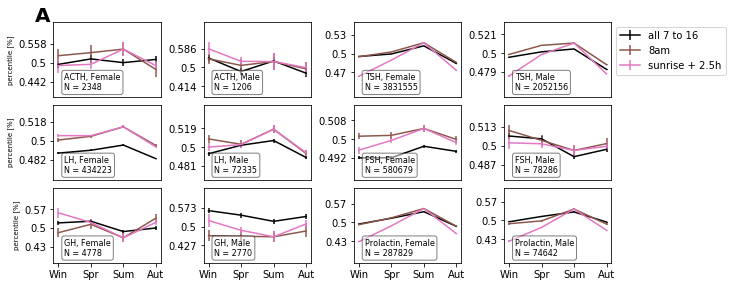

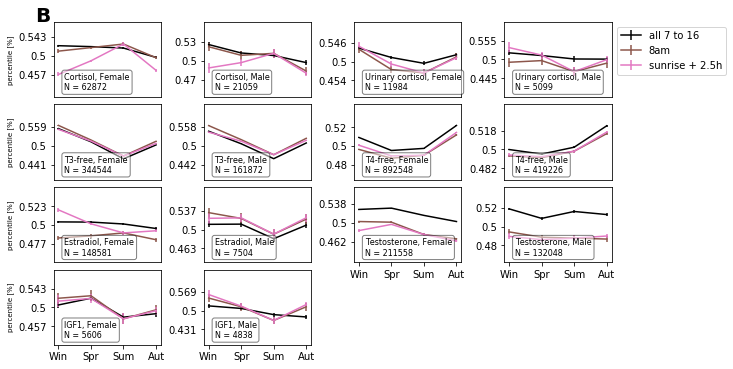

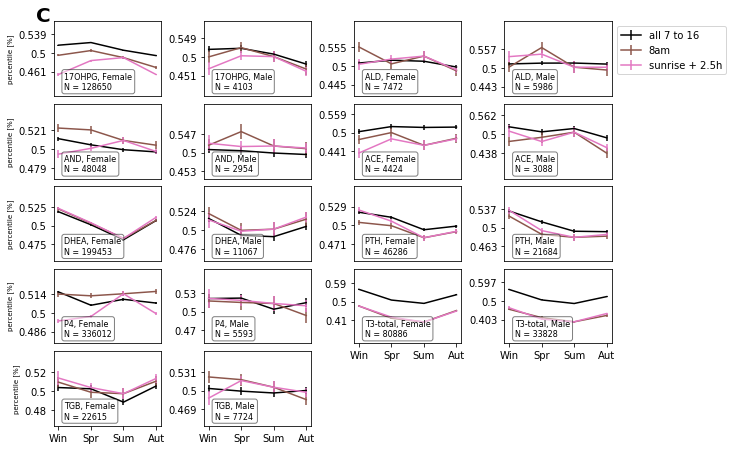

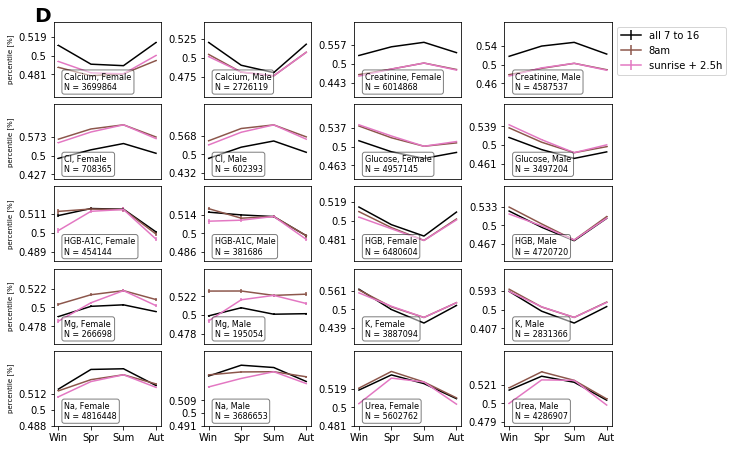

In [4]:
def plot_circadian_seasonality_method(hormone_dic,title='',A=''):
    dtype = 'quantile';corr_summery=[]; ab_res=[]
    plt.figure(figsize=(10,1.5*len(hormone_dic)))
    pi=1
    for h,hormone in tqdm(enumerate(hormone_dic.keys())):
        for s,sex in enumerate(['female','male']):
            file    = '../data/Clalit_seasonality_Nov19/clock.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_80.csv'
            df = pd.read_csv(file)
            df['hour'] = df['hour']+12
            df.loc[df['hour']>24,['hour']] = df.loc[df['hour']>24,['hour']] - 24
            df = df.loc[df['hour']>6]
            df = df.loc[df['hour']<17]
            df_clean = df.loc[df['n']>20].copy()
            df_clean = df_clean.loc[df_clean['type']==sex].copy()

            n_ticks = np.arange(7,17,1)#np.unique(df_clean.hour.values)
            
            i=1
            season_mean_std = []
            P = []
 
            ax = plt.subplot(len(hormone_dic),4,pi)
            check_corr = []
            res = seasonal_time_process_all(hormone,sex);  check_corr.append(res['mean'].values)
            ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c='k')
            res = seasonal_time_process_8am(hormone,sex);  check_corr.append(res['mean'].values)
            ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c=def_color[5])
            res = seasonal_time_process_sunrise_phase(hormone,sex);  check_corr.append(res['mean'].values)
            ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c=def_color[6])
            corr_summery.append(pd.DataFrame(np.array(check_corr).T).corr().values.flat[[1,2,5]].mean())
            
            ax.set_xticks(res.index)
            ax.set_xticklabels(res.seasons,fontsize=10)
            
            if h== 0:
                if s==0:
                    ax.text(-0.03, 1.2, A, transform=ax.transAxes,fontsize = 20, fontweight='bold', va='top', ha='right')
            
            y = (np.array(ax.get_ylim()).max() - np.array(ax.get_ylim()).min())
            ax.set_ylim([np.array(ax.get_ylim()).mean()-y,np.array(ax.get_ylim()).mean()+y])

            ax.text(0.1, 0.325, hormone_dic[hormone] + ', ' + sex.capitalize() + '\nN = ' + str(df_clean['n'].sum()),
                    transform=ax.transAxes, fontsize=8, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='black',alpha=0.5))            
            ax.set_yticks([0.5-y/2,0.5,0.5+y/2])
            ax.set_yticklabels(np.round(ax.get_yticks(),decimals=3),fontsize=10)
                
            if np.mod(pi-1,4) == 0:
                ax.set_ylabel('percentile [%]',fontsize=7)

            
            if h < len(hormone_dic)-2:
                ax.set_xticks([])
                
            if h == 1:
                if s == 1:
                    ax.legend(['all 7 to 16','8am','sunrise + 2.5h'],bbox_to_anchor=(1,1))  
            pi +=1
    plt.subplots_adjust(hspace=0.1,wspace=0.4)
#     plt.savefig('../figures/Seasonality160620/SI_circ_methods_' + title+'_.pdf',bbox_inches='tight',dpi=600)
    plt.show()
    return corr_summery,pd.DataFrame(ab_res,columns = ['Hormone','sex','season1','season2','a','b','r','pval','effect_size'])

corr_pit,df_pit = plot_circadian_seasonality_method(pituitary_hormone_dic,title='pit',A='A')
corr_eff,df_eff = plot_circadian_seasonality_method(effector_hormone_dic,title='eff',A='B')
corr_add,df_chm = plot_circadian_seasonality_method(residual_hormone_dic,title='add',A='C')
corr_add,df_chm = plot_circadian_seasonality_method(chem_dic,title='chm',A='D')

# Plot Fig S2
# 4-seasons time-of-day distribution for all tests and sex

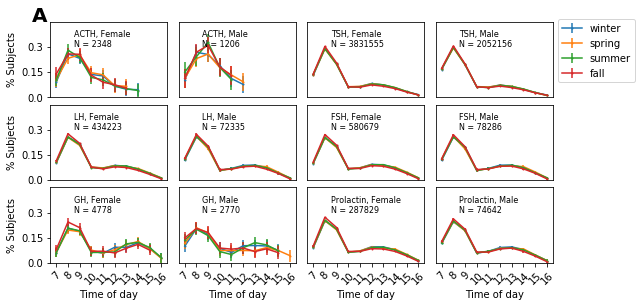

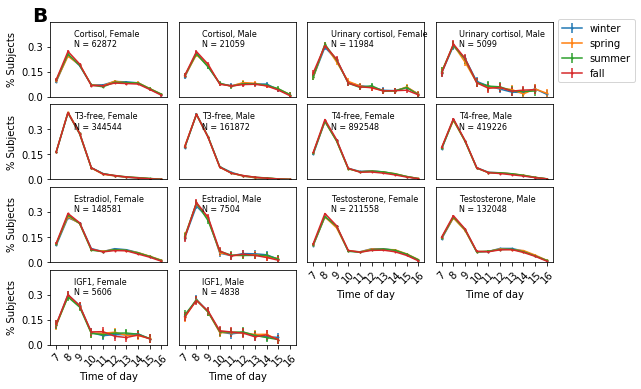

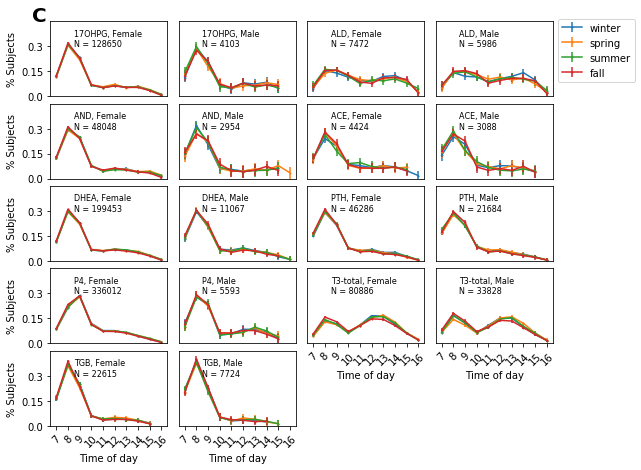

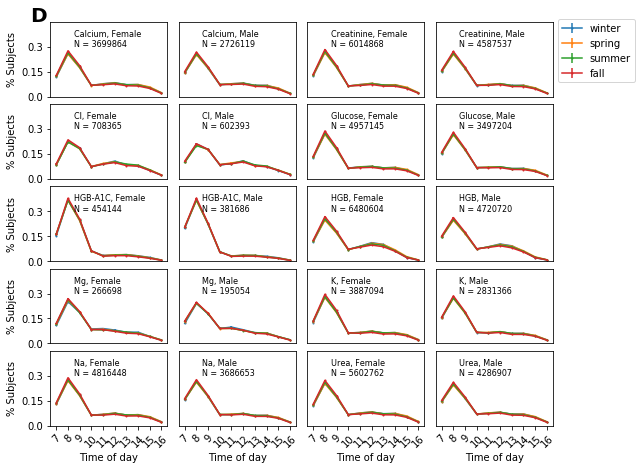

In [5]:
def plot_circadian_seasonality_dist_short(hormone_dic,title='',A=''):
    dtype = 'quantile';corr_summery=[]; ab_res=[]
    plt.figure(figsize=(9,1.5*len(hormone_dic)))
    pi = 1
    for h,hormone in tqdm(enumerate(hormone_dic.keys())):
        for s,sex in enumerate(['female','male']):
            file    = '../data/Clalit_seasonality_Nov19/clock.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_80.csv'
            df = pd.read_csv(file)
            df['hour'] = df['hour']+12
            df.loc[df['hour']>24,['hour']] = df.loc[df['hour']>24,['hour']] - 24
            df = df.loc[df['hour']>6]
            df = df.loc[df['hour']<17]
            df_clean = df.loc[df['n']>20].copy()
            df_clean = df_clean.loc[df_clean['type']==sex].copy()

            n_ticks = np.arange(7,17,1)#np.unique(df_clean.hour.values)
            
            i=1
            season_mean_std = []
            P = []
            ax = plt.subplot(len(hormone_dic),4,pi)
            
            if h== 0:
                if s==0:
                    ax.text(-0.03, 1.2, A, transform=ax.transAxes,fontsize = 20, fontweight='bold', va='top', ha='right')
            
            p_compare    = np.zeros((4,10))
            n_compare    = np.zeros((4,10))
            perr_compare = np.zeros((4,10)); k =0
            for season,sub_loc in zip(['winter','spring','summer','fall'],[1,2,4,5]):
                sdf = df_clean.loc[df_clean['season'] == season]
                hsdf_ = sdf.sort_values('hour')
                p    = hsdf_.n.values/hsdf_.n.values.sum()
                perr = np.sqrt((p*(1-p))/hsdf_.n.values)
                ax.errorbar(hsdf_.hour.values,p,perr,fmt='-o',ms=1)
                ax.set_ylim([0,0.45])
                P.append(np.sum(p[0:6]))
                season_mean_std.append([np.sum(hsdf_['mean'].values*(hsdf_['n'].values/np.sum(hsdf_['n'].values))),
                                       np.mean(hsdf_['std'].values)/np.sqrt(np.sum(hsdf_['n'].values))])
                p_compare[k,:len(p)]    = p
                perr_compare[k,:len(p)] = perr
                n_compare[k,:len(p)]    = hsdf_.n.values; k+=1
                
            df_p = pd.DataFrame(p_compare.T)
            df_e = pd.DataFrame(perr_compare.T)
            df_n = pd.DataFrame(n_compare.T)
            for comb in  list(combinations(range(4),2)):
                ab_res.append(regress_seasons_with_xy_error(hormone_dic[hormone],sex,df_p,df_e,df_n,s1=comb[0],s2=comb[1],to_plot=False))    
            
            ax.set_xlim([6.5,16.5])
            ax.set_xticks(n_ticks)
            ax.set_xticklabels(n_ticks,fontsize=10,rotation=45)
            ax.annotate(hormone_dic[hormone] + ', ' + sex.capitalize() + '\nN = ' + str(df_clean['n'].sum()),
                      (8.5,0.3),fontsize=8) 
            
            if np.mod(pi-1,4) == 0:
                ax.set_ylabel('% Subjects',fontsize=10)
                ax.set_yticks([0,0.15,0.3])
                ax.set_yticklabels(ax.get_yticks(),fontsize=10)
            else:
                ax.get_yaxis().set_visible(False)
                
            if h < len(hormone_dic)-2:
                ax.set_xticks([])
            else:
                ax.set_xlabel('Time of day')
            
            if h == 1:
                if s == 1:
                    ax.legend(['winter','spring','summer','fall'],bbox_to_anchor=(1,1.1))  
            pi+=1
    plt.subplots_adjust(hspace=0.1,wspace=0.1)
#     plt.savefig('../figures/Seasonality160620/SI_circ_dist' + title + '_.pdf',bbox_inches='tight',dpi=600)
    plt.show()
    return corr_summery,pd.DataFrame(ab_res,columns = ['Hormone','sex','season1','season2','a','b','r','pval','effect_size'])

corr_pit,df_pit = plot_circadian_seasonality_dist_short(pituitary_hormone_dic,title='pit',A='A')
corr_eff,df_eff = plot_circadian_seasonality_dist_short(effector_hormone_dic,title='eff',A='B')
corr_add,df_chm = plot_circadian_seasonality_dist_short(residual_hormone_dic,title='add',A='C')
corr_add,df_chm = plot_circadian_seasonality_dist_short(chem_dic,title='chm',A='D')

# Plot Fig S3
# Summery of time-of-day distribution seasonal effect

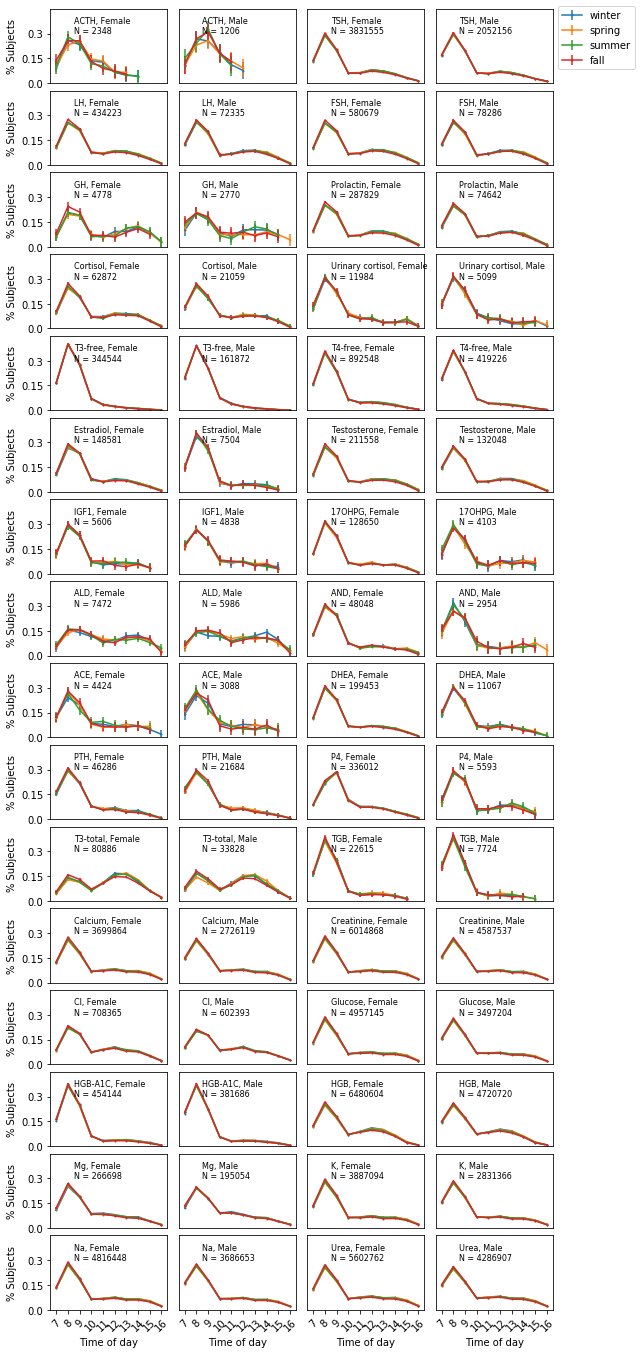

D:\Anaconda\envs\venv\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


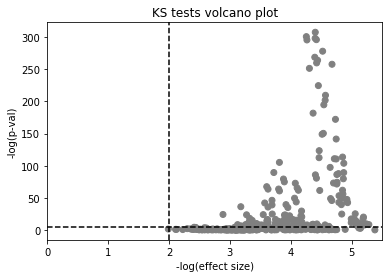

In [6]:
summery,df_all = plot_circadian_seasonality_dist_short(
                {**pituitary_hormone_dic,**effector_hormone_dic,**residual_hormone_dic,**chem_dic},title='all',A='')
alpha       = 0.05
threshold   = alpha/len(df_all)
p_list      = df_all['pval'].values
p_corr_list = FDR(p_list,alpha=alpha)
df_all['Pass FDR'] = p_corr_list[0] 
df_all['q_values'] = p_corr_list[1] 

df_dfr = volcano(df_all,lfc='effect_size',pv='pval',lfc_thr=0.01,pv_thr=threshold,FDR=True)
plt.xlabel('-log(effect size)')
plt.ylabel('-log(p-val)')
plt.title('KS tests volcano plot')
plt.xlim([0,5.5])
df_dfr.loc[df_dfr.color!='grey']
# plt.savefig('../figures/Seasonality160620/SI_circ_dist_KS_summery.pdf',bbox_inches='tight',dpi=600)

# SI figures S5-S6

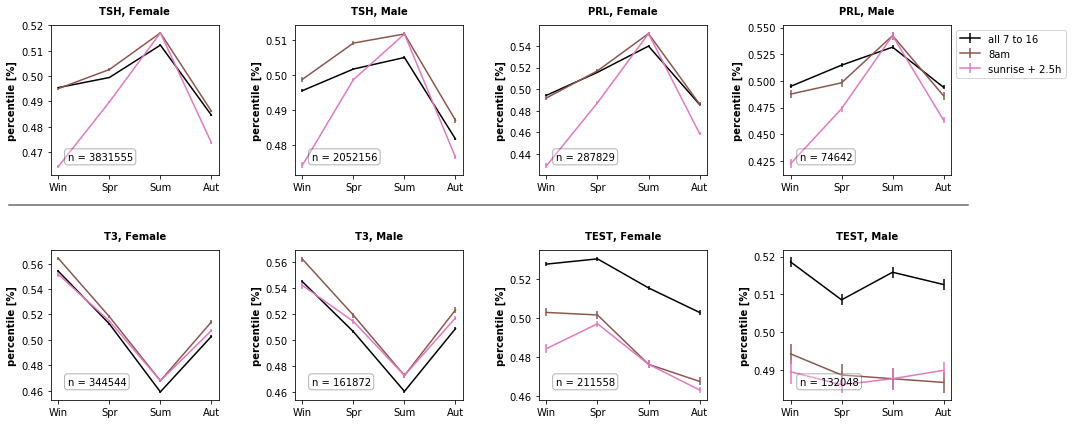

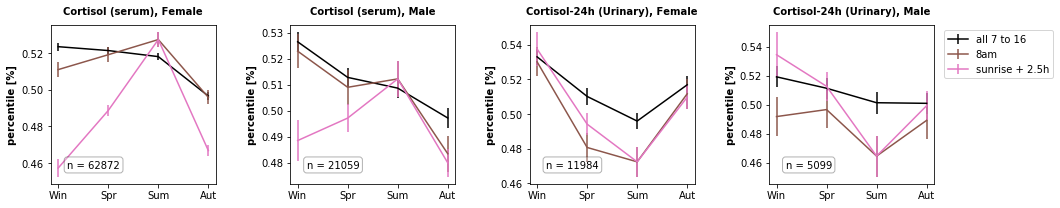

In [7]:
circadian_hormone_list      =['TSH_THYROID_STIMULATING_HORMONE','PROLACTIN','T3_FREE','TESTOSTERONE_TOTAL']
circadian_hormone_list_short=['TSH','PRL','T3','TEST']

fig = plt.figure(figsize=(15,6))
dtype = 'quantile'; ''
for h,hormone in tqdm(enumerate(circadian_hormone_list)):
    for i,sex in enumerate(['female','male']):

        file    = '../data/Clalit_seasonality_Nov19/clock.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_80.csv'
        df = pd.read_csv(file)
        df['hour'] = df['hour']+12
        df.loc[df['hour']>24,['hour']] = df.loc[df['hour']>24,['hour']] - 24
        
        df = df.loc[df['hour']>6]
        df = df.loc[df['hour']<17]
    
        df_clean = df.loc[df['n']>20].copy()
        df_clean = df_clean.loc[df_clean['type']==sex].copy()
        
        n_ticks = np.unique(df_clean.hour.values)
        ax = plt.subplot(2,4,1+h*2+i); 
        res = seasonal_time_process_all(hormone,sex)
        ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c='k')
        res = seasonal_time_process_8am(hormone,sex)
        ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c=def_color[5])
        res = seasonal_time_process_sunrise_phase(hormone,sex)
        ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c=def_color[6])

        ax.set_xticks(res.index)
        ax.set_xticklabels(res.seasons)
        ax.set_ylabel('percentile [%]',fontweight='bold')
        ax.set_title(circadian_hormone_list_short[h] + ', ' + sex.capitalize(),
                     y=1.03,fontweight='bold',fontsize=10)
        ax.text(0.1,0.1,'n = ' + str(df_clean['n'].sum()),transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='white', edgecolor='black',alpha=.3))
                     
        if 1+i+2*h ==4: 
            ax.legend(['all 7 to 16','8am','sunrise + 2.5h'],bbox_to_anchor=(1,1))  
            
# plt.suptitle(circadian_hormone_list_short[h],y=1.01,fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(hspace=0.5,wspace=0.45)
line = plt.Line2D([1.1,-4.6],[1.3,1.3], transform=ax.transAxes, color="dimgray",zorder=-4);fig.add_artist(line) 
# plt.savefig('../figures/Seasonality11022020/SI_circadian_hormones_1102.pdf',bbox_inches='tight',dpi=600)
plt.show()

cortisol_hormone_list        = ['CORTISOL_BLOOD','CORTISOL_U_FREE_24h']
cortisol_hormone_list_short = [ 'Cortisol (serum)','Cortisol-24h (Urinary)']

fig = plt.figure(figsize=(15,3))
dtype = 'quantile'; 
for h,hormone in tqdm(enumerate(cortisol_hormone_list)):
    for i,sex in enumerate(['female','male']):

        file    = '../data/Clalit_seasonality_Nov19/clock.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_80.csv'
        df = pd.read_csv(file)
        df['hour'] = df['hour']+12
        df.loc[df['hour']>24,['hour']] = df.loc[df['hour']>24,['hour']] - 24
        
        df = df.loc[df['hour']>6]
        df = df.loc[df['hour']<17]
    
        df_clean = df.loc[df['n']>20].copy()
        df_clean = df_clean.loc[df_clean['type']==sex].copy()
        
        n_ticks = np.unique(df_clean.hour.values)
        ax = plt.subplot(1,4,i+h*2+1); 
        res = seasonal_time_process_all(hormone,sex)
        ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c='k')
        res = seasonal_time_process_8am(hormone,sex)
        ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c=def_color[5])
        res = seasonal_time_process_sunrise_phase(hormone,sex)
        ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c=def_color[6])
   
        ax.set_xticks(res.index)
        ax.set_xticklabels(res.seasons)
        ax.set_ylabel('percentile [%]',fontweight='bold')
        ax.set_title(cortisol_hormone_list_short[h] + ', ' + sex.capitalize(),
                     y=1.03,fontweight='bold',fontsize=10)
        ax.text(0.1,0.1,'n = ' + str(df_clean['n'].sum()),transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='black',alpha=.3))
                   
        if 1+i+2*h ==4: 
            ax.legend(['all 7 to 16','8am','sunrise + 2.5h'],bbox_to_anchor=(1.75,1))  
             
plt.tight_layout()
plt.subplots_adjust(hspace=0.5,wspace=0.45)
# plt.savefig('../figures/Seasonality160620/SI_circadian_and_cortisol.pdf',bbox_inches='tight',dpi=600)
plt.show()

In [8]:
def plot_circadian_seasonality(hormone_dic):
    dtype = 'quantile'
    corr_summery=[]; ab_res=[]
    for h,hormone in tqdm(enumerate(hormone_dic.keys())):
        for sex in ['female','male']:

            file    = '../data/Clalit_seasonality_Nov19/clock.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_80.csv'
            df = pd.read_csv(file)
            df['hour'] = df['hour']+12
            df.loc[df['hour']>24,['hour']] = df.loc[df['hour']>24,['hour']] - 24

            df = df.loc[df['hour']>6]
            df = df.loc[df['hour']<17]

            df_clean = df.loc[df['n']>20].copy()
            df_clean = df_clean.loc[df_clean['type']==sex].copy()

            n_ticks = np.arange(7,17,1)#np.unique(df_clean.hour.values)
            fig = plt.figure(figsize=(15,3))

            i=1
            season_mean_std = []
            P = []
            ax = plt.subplot(1,5,1)
            ks_compare = np.zeros((4,10)); k =0
            for season,sub_loc in zip(['winter','spring','summer','fall'],[1,2,4,5]):
                sdf = df_clean.loc[df_clean['season'] == season]
                hsdf_ = sdf.sort_values('hour')
                p    = hsdf_.n.values/hsdf_.n.values.sum()
                perr = np.sqrt((p*(1-p))/hsdf_.n.values)
                ax.errorbar(hsdf_.hour.values,p,perr,fmt='-o')
                ax.set_ylim([0,0.6])
                P.append(np.sum(p[0:6]))
                season_mean_std.append([np.sum(hsdf_['mean'].values*(hsdf_['n'].values/np.sum(hsdf_['n'].values))),
                                       np.mean(hsdf_['std'].values)/np.sqrt(np.sum(hsdf_['n'].values))])
                ks_compare[k,:len(p)] = p; k+=1
     
            ks_res = [] 
            for comb in  list(combinations(range(4), 2)):
                if ks_2samp(ks_compare[comb[0],:],ks_compare[comb[1],:])[1] < 0.05:
                    print(hormone, sex, ['winter','spring','summer','fall'][comb[0]],
                                        ['winter','spring','summer','fall'][comb[1]])
            ax.set_xlim([6.5,16.5])
            ax.set_xticks(n_ticks)
            ax.set_xlabel('Time of day',fontweight='normal')
            ax.set_ylabel('% subjects',fontweight='normal')

            ax = plt.subplot(1,5,5)
            check_corr = []

            res = seasonal_time_process_all(hormone,sex);  check_corr.append(res['mean'].values)
            ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c='k')

            res = seasonal_time_process_8am(hormone,sex);  check_corr.append(res['mean'].values)
            ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c=def_color[5])

            res = seasonal_time_process_sunrise_phase(hormone,sex);  check_corr.append(res['mean'].values)
            ax.errorbar(res.index,res['mean'],res['std']/np.sqrt(res['n']),c=def_color[6])

            ax.set_xticks(res.index)
            ax.set_xticklabels(res.seasons)
            ax.set_ylabel('percentile [%]',fontweight='normal')
#             ax.legend(['all 7 to 16','8am','sunrise + 2.5h'],bbox_to_anchor=(1, 0.5))

            corr_summery.append(pd.DataFrame(np.array(check_corr).T).corr().values.flat[[1,2,5]].mean())

            ax = plt.subplot(1,5,2)
            season_mean_std = []
            ab_fit = np.zeros((4,10)); k =0
            for j,season in enumerate(['winter','spring','summer','fall']):

                sdf = df_clean.loc[df_clean['season'] == season]
                hsdf_ = sdf.sort_values('hour')
                ax.errorbar(hsdf_.hour.values,
                            hsdf_['mean'].values,
                            yerr = hsdf_['std'].values/np.sqrt(hsdf_.n.values),
                            fmt='-o',c=def_color[j])
                
                ab_fit[k,:len(hsdf_)] = hsdf_['mean'].values; k+=1
            ax.set_xlim([6.5,16.5])
    
            ylm = ax.get_ylim()    
            df = pd.DataFrame(ab_fit)
            df = df.drop(columns=df.columns[(df==0).sum()>0])
                
            winter    = df.iloc[0]
            daytime   = range(len(winter))
            intwint = interp1d(daytime,winter,fill_value='extrapolate',kind='cubic')
            yerr      = (hsdf_['std'].values/np.sqrt(hsdf_.n.values))
            p_range    = np.diff(np.array(ax.get_ylim()))[0]
            time_range = np.diff(np.array(ax.get_xlim()))[0]  
            
            def func(x,a,b,c):
                return c*(intwint(x+b)) +a
            
            bounds = ((-0.5,-4,0.2),(0.5,4,5))
            
            for i in [1,2,3]:
                a,b,c = curve_fit(f=func,xdata=daytime,ydata=df.iloc[i],p0=[0,0,1],bounds=bounds,sigma=yerr)[0]*[1,1,1]
                ab_res.append([a,c*b*df.iloc[i].diff().abs().max(),c])
                
            ax.set_ylabel('percentile [%]',fontweight='bold')
            ax.set_xticks(n_ticks)
            ax.set_xlabel('Time of day',fontweight='bold')

            a,b,c = np.mean(np.abs([curve_fit(f=func, xdata=daytime, ydata=df.iloc[i],p0=[0,0,1],bounds=bounds,sigma=yerr)[0] for i in [1,2,3]]),axis=0)
            ax3 = plt.subplot(1,5,3)
            ax3.set_ylabel('percentile [%]',fontweight='bold')
            ax3.set_xticks(n_ticks)
            
            ax4 = plt.subplot(1,5,4)
            
            for i in [1,2,3]:
                popt,pcov = curve_fit(f=func, xdata=daytime, ydata=df.iloc[i],p0=[0,0,1],bounds=bounds,sigma=yerr)
                a_bf,b_bf,c_bf = popt
                ax3.plot(hsdf_.hour.values,func(daytime,a_bf,b_bf,c_bf),'--',zorder=4,lw=2,c=def_color[i])
                ax3.set_ylim(ylm)
                ax3.set_xlim([6.5,16.5])
                ax3.set_xlabel('Time of day',fontweight='bold')
                R_bf      = np.sum((df.iloc[i] - func(daytime,a_bf,b_bf,c_bf))**2) 
                As        = a_bf*np.arange(0,2.1,0.1)
                Bs        = b_bf*np.arange(0,2.1,0.1)
                R_a       = [np.sum((df.iloc[i]  - func(daytime,a,b_bf,c_bf))**2) for a in As]
                R_b       = [np.sum((df.iloc[i]  - func(daytime,a_bf,b,c_bf))**2) for b in Bs]
                ax4.plot((As - a_bf)/a_bf,(R_a - R_bf)/R_bf,c=def_color[0])
                ax4.plot((Bs - b_bf)/b_bf,(R_b - R_bf)/R_bf,c=def_color[1])
            ax4.set_xlim([-1,1])    
            ax4.set_xlabel('parameter best fit deviation',fontweight='bold')
            ax4.set_ylabel('residual error \n(normalized to best fit)',fontweight='bold')
            ax4.legend(['a','b'])
            plt.tight_layout()
            plt.suptitle(hormone_dic[hormone] + ', ' + sex.capitalize() + ', N = ' + str(df_clean['n'].sum()),y=1.03,fontweight='bold') 
    plt.show()
    return corr_summery,pd.DataFrame(ab_res,columns = ['a','b','c'])

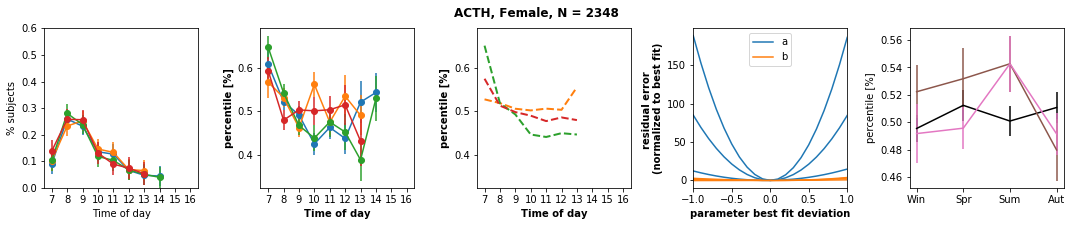

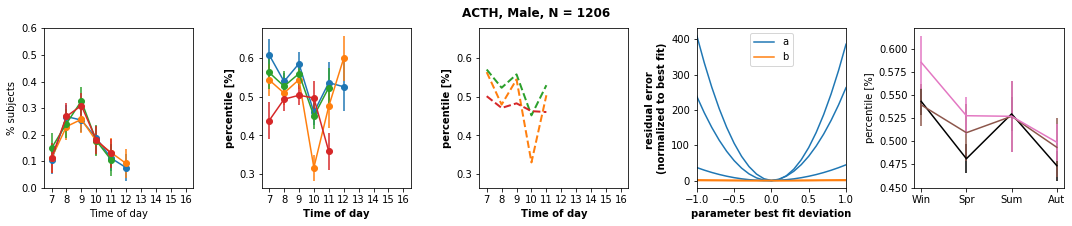

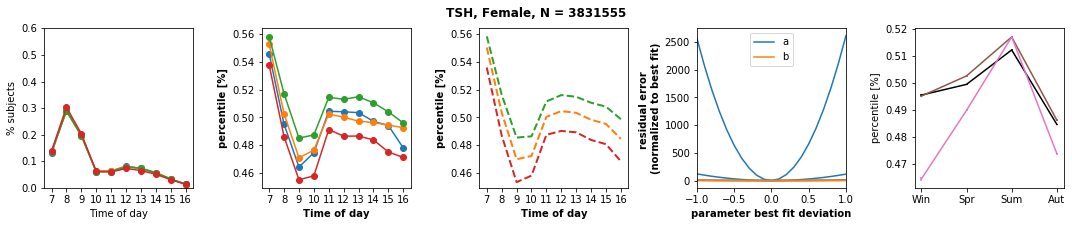

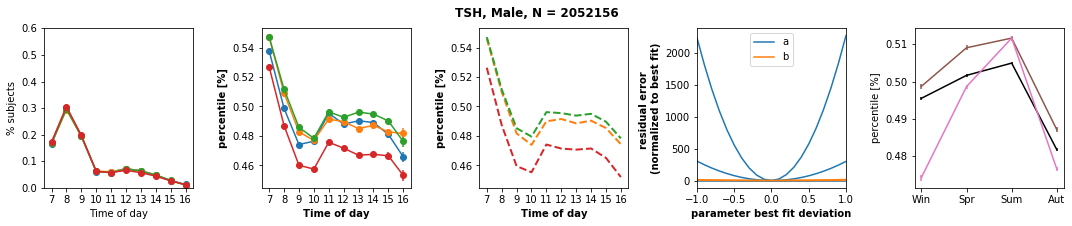

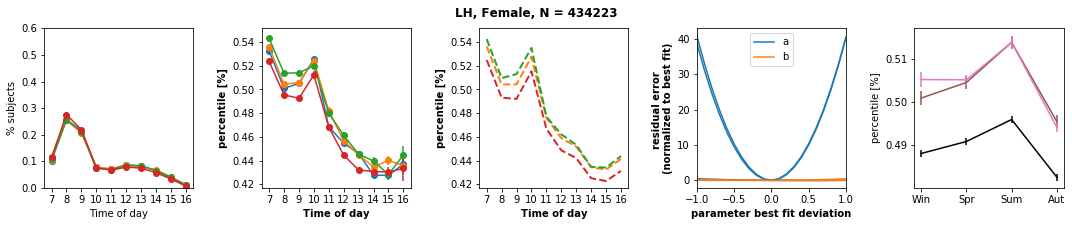

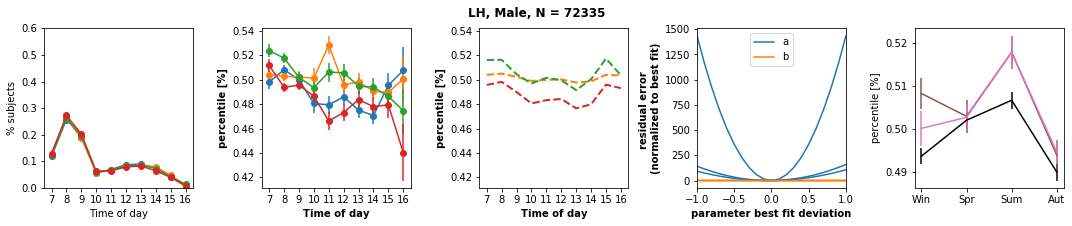

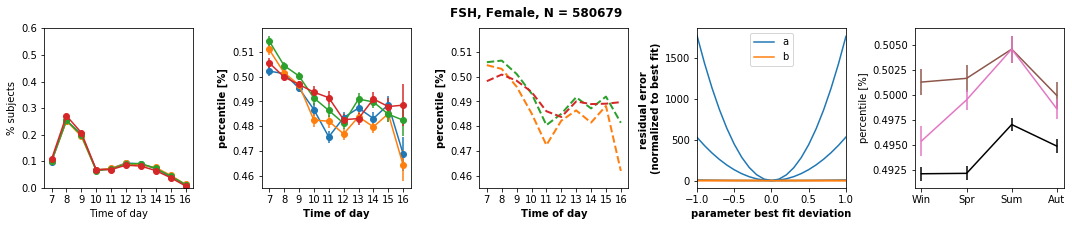

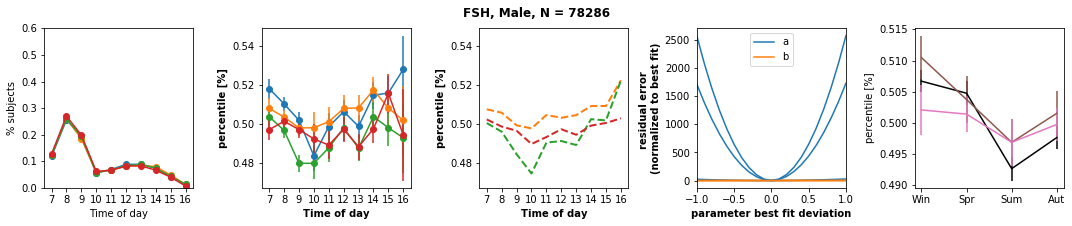

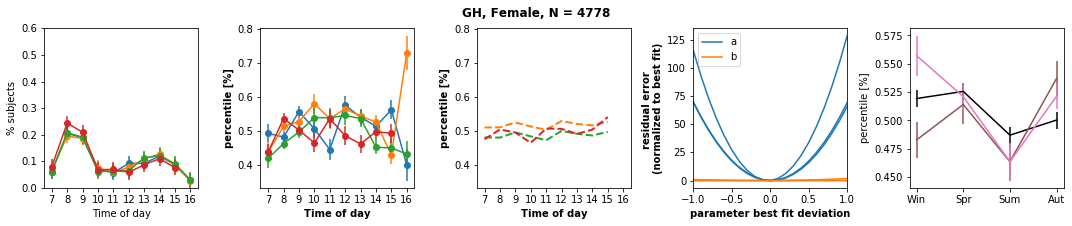

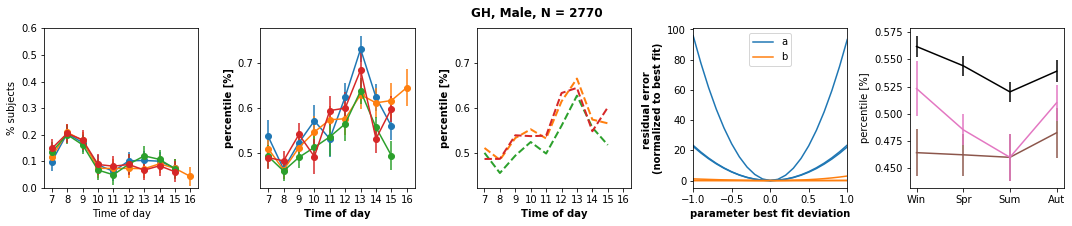

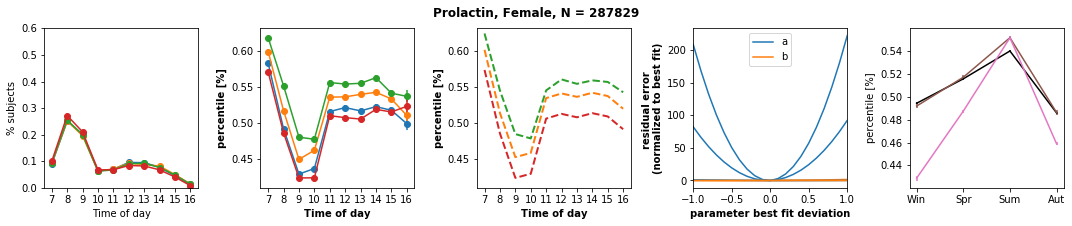

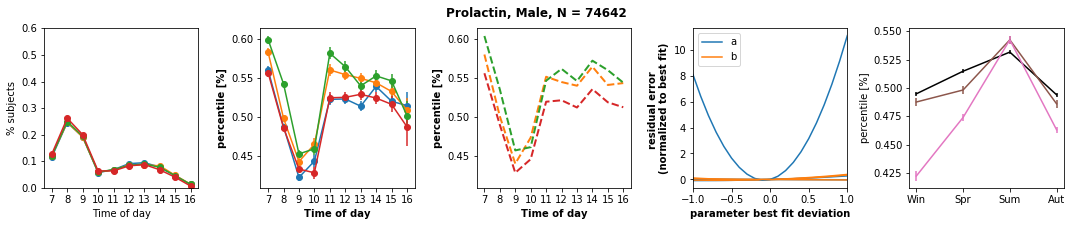

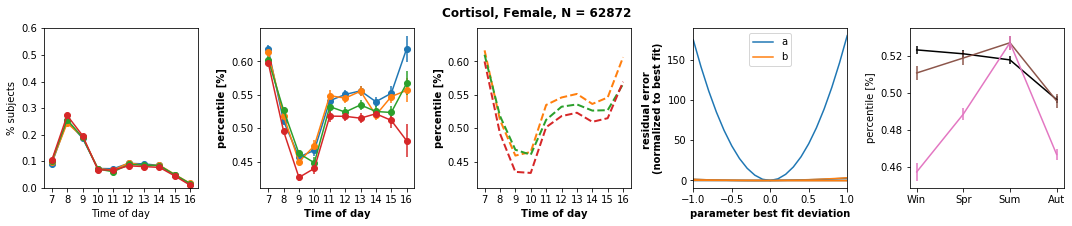

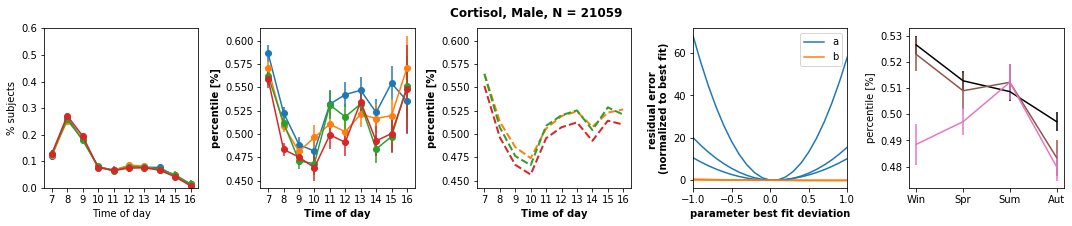

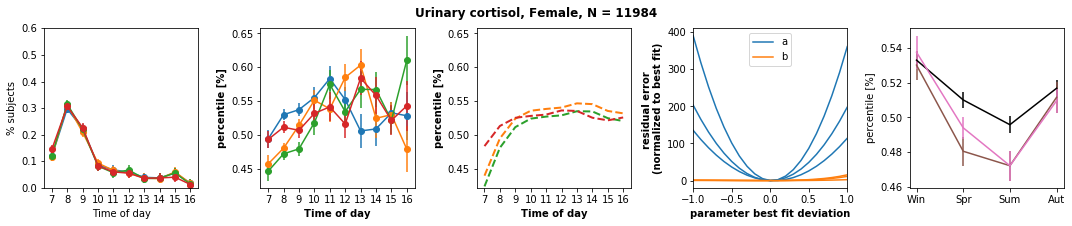

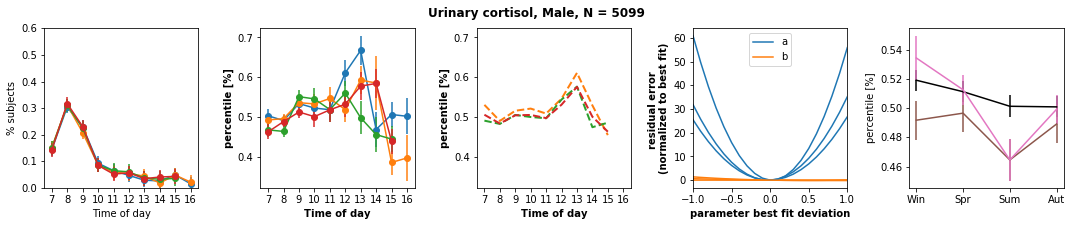

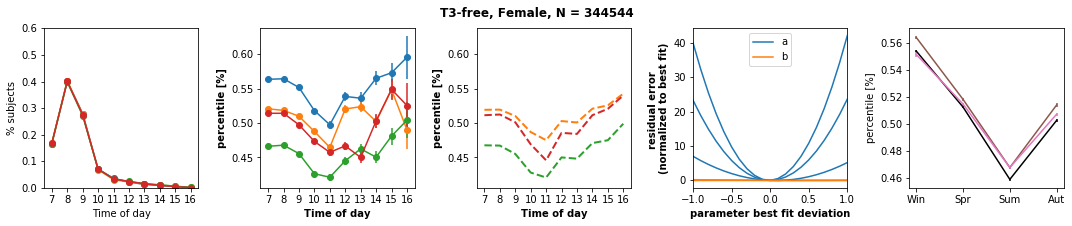

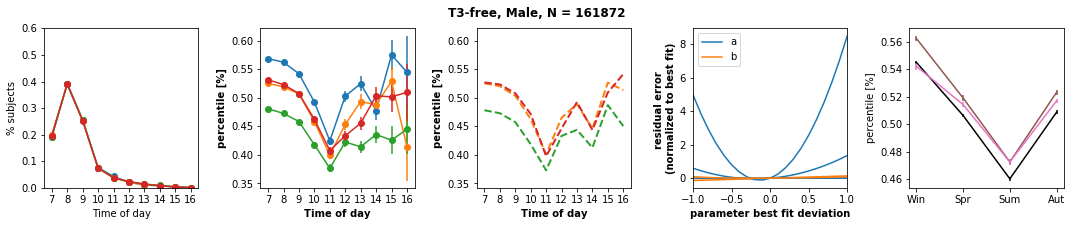

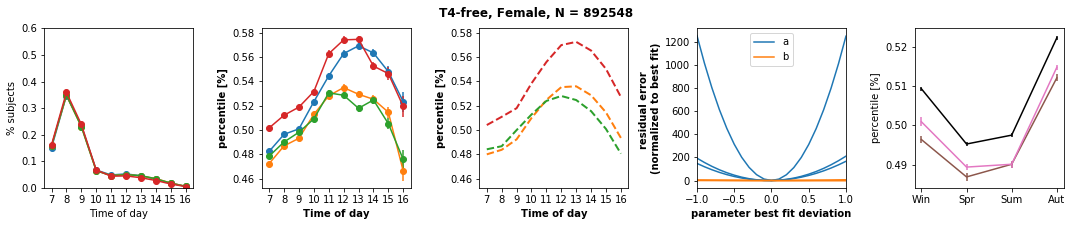

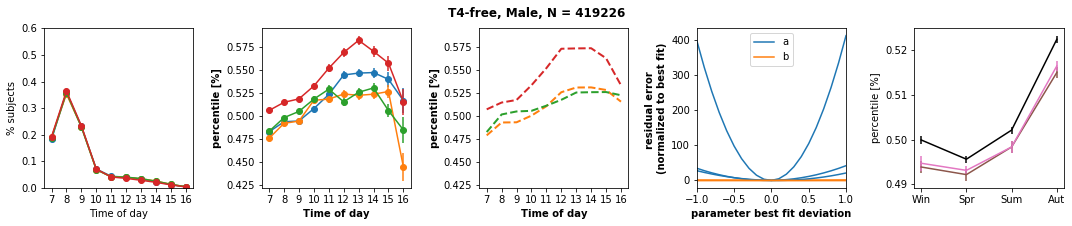

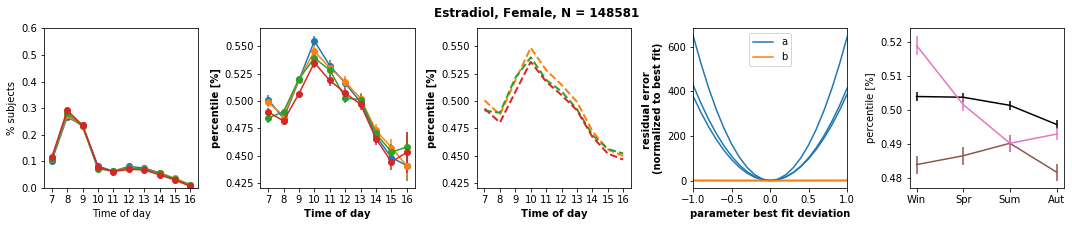

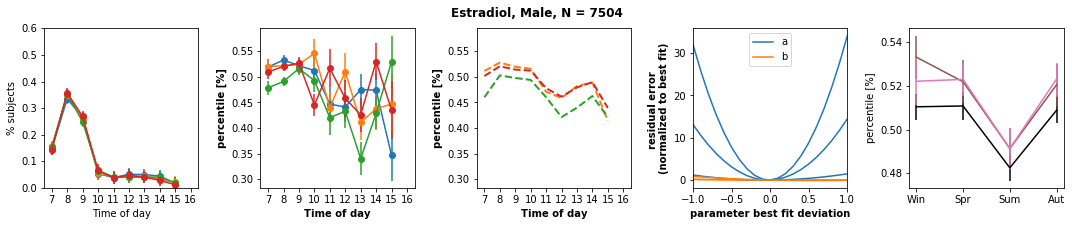

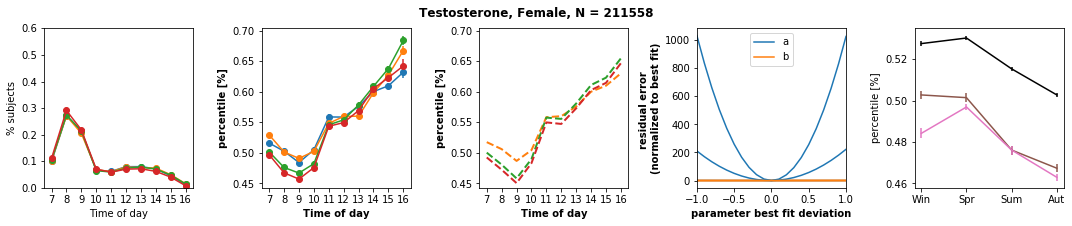

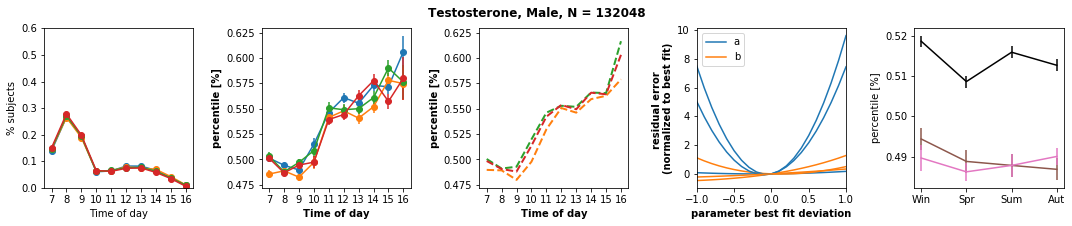

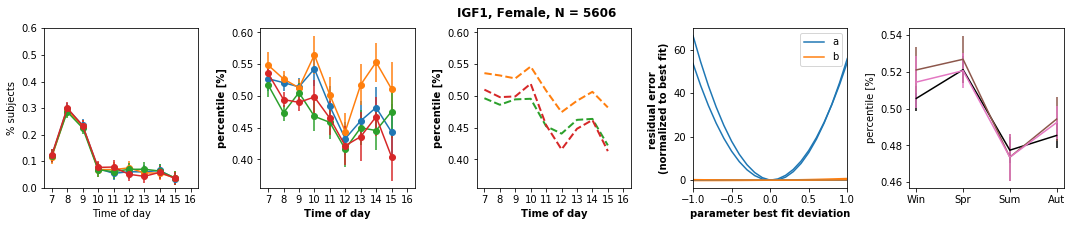

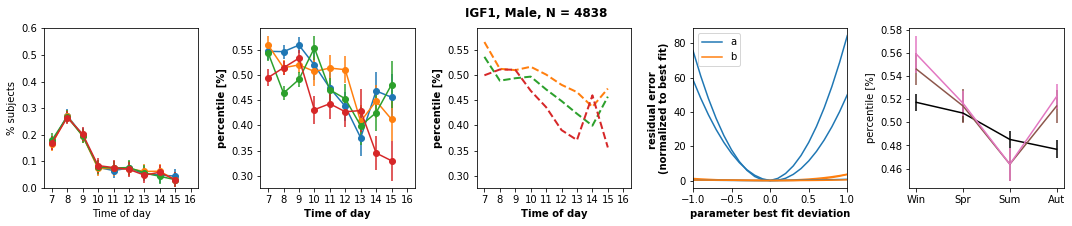

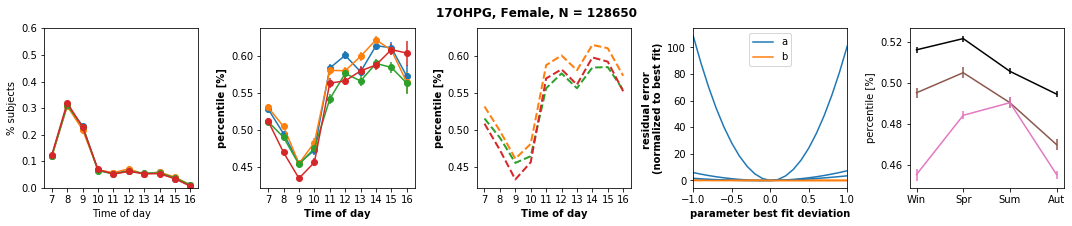

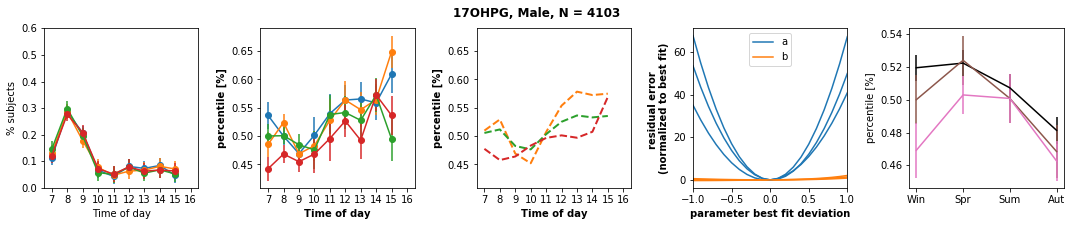

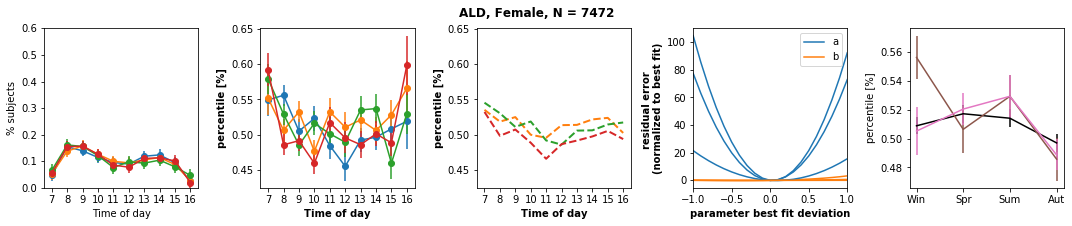

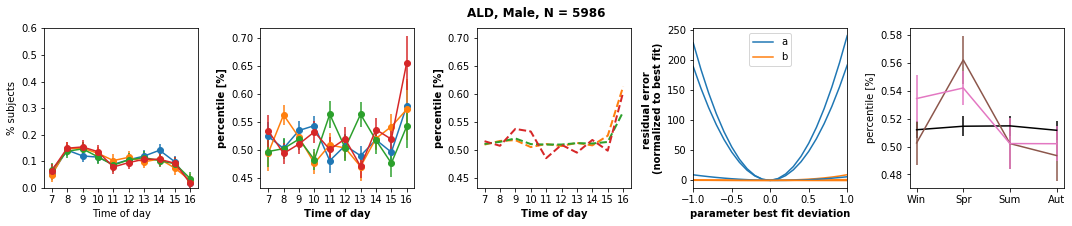

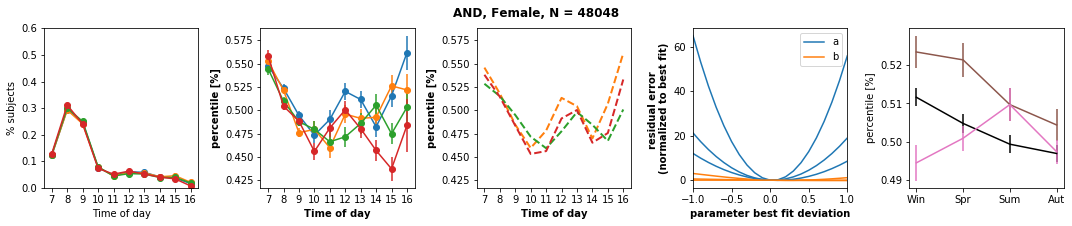

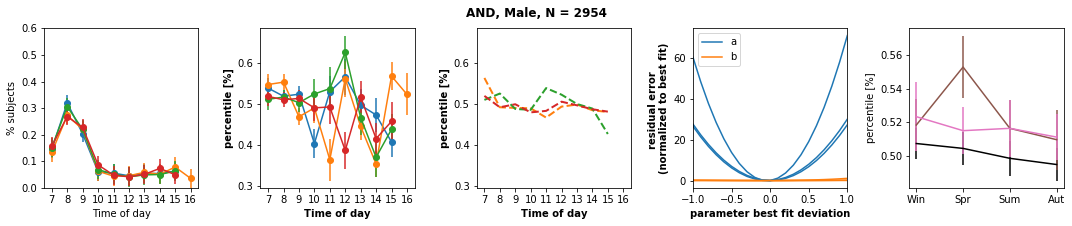

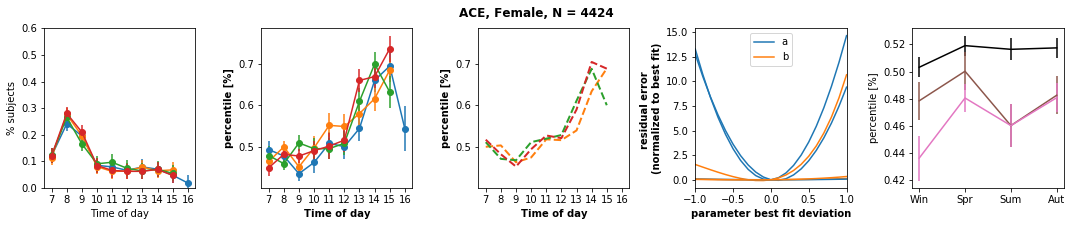

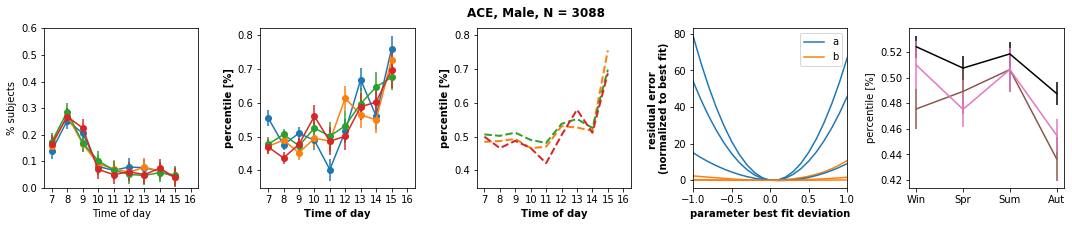

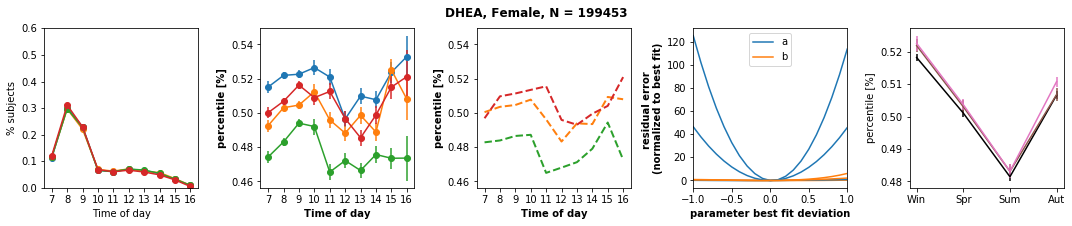

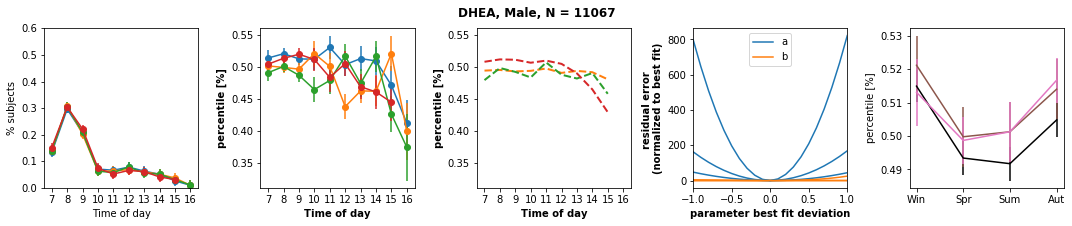

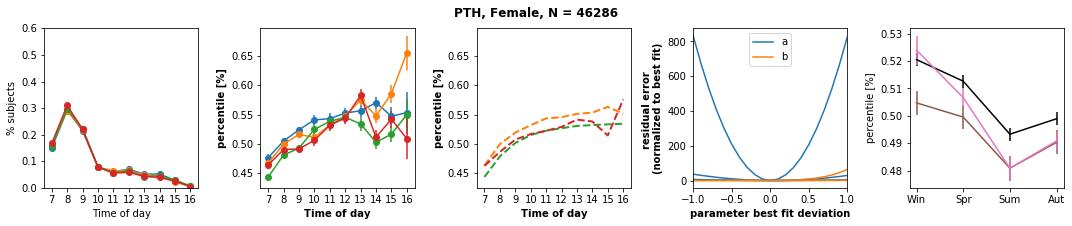

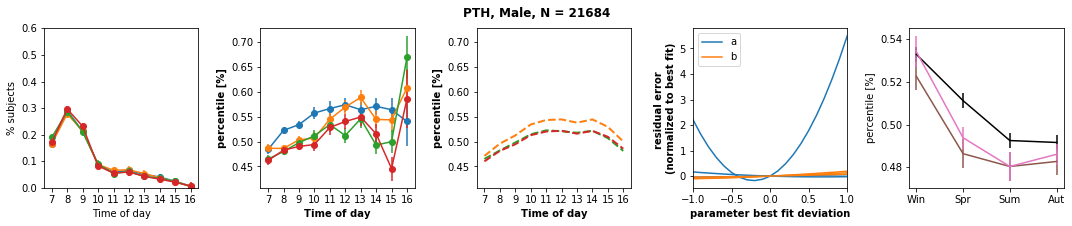

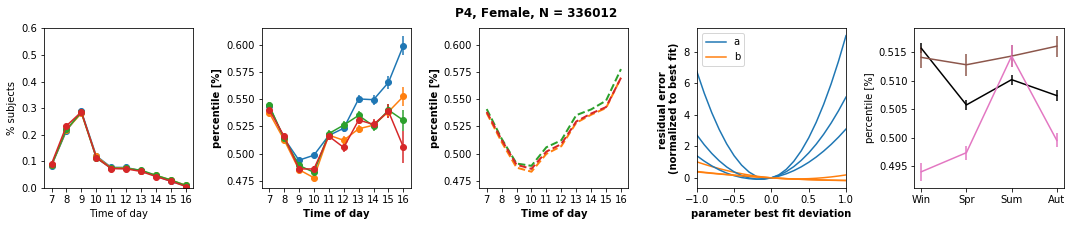

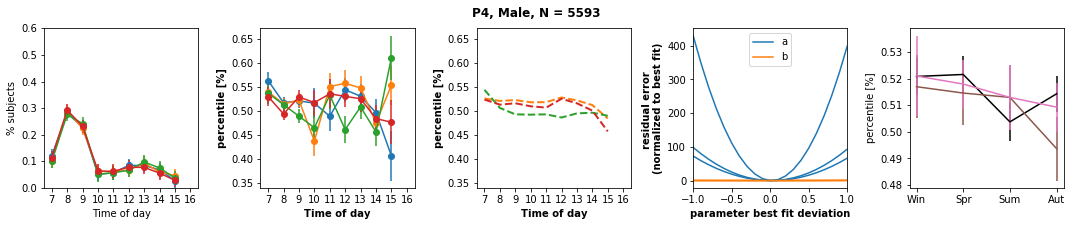

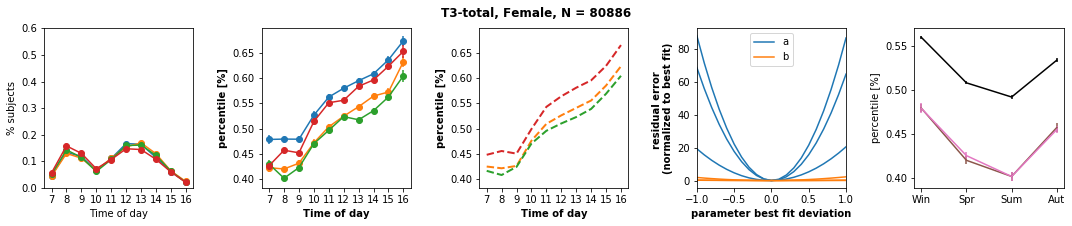

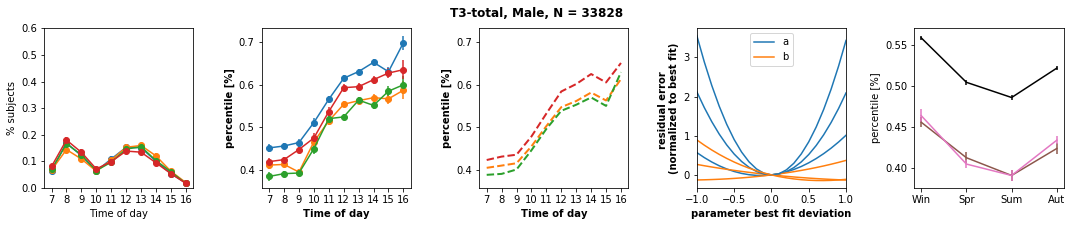

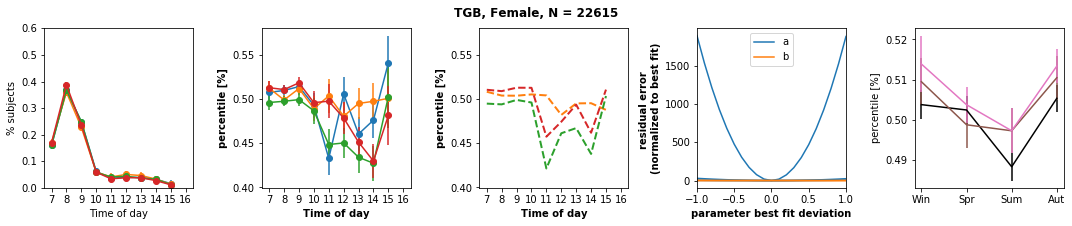

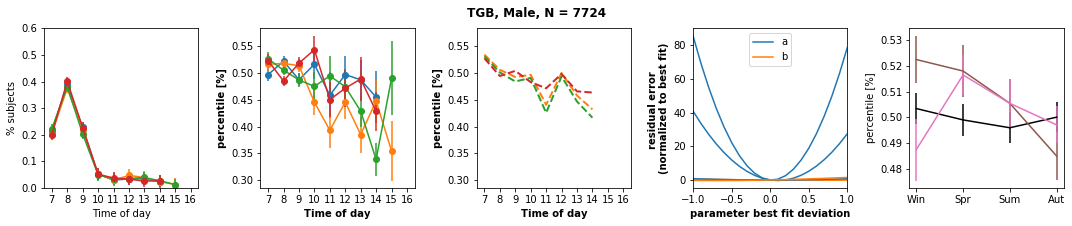

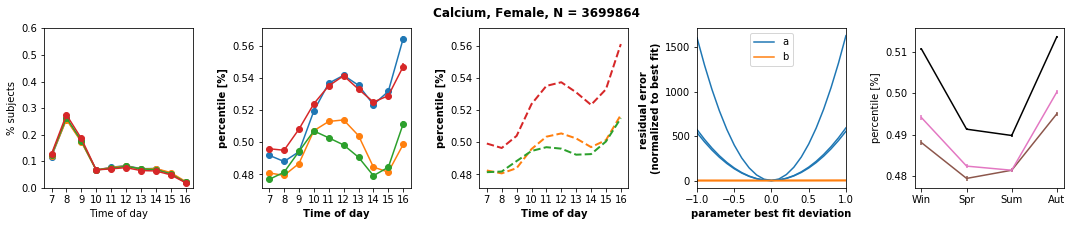

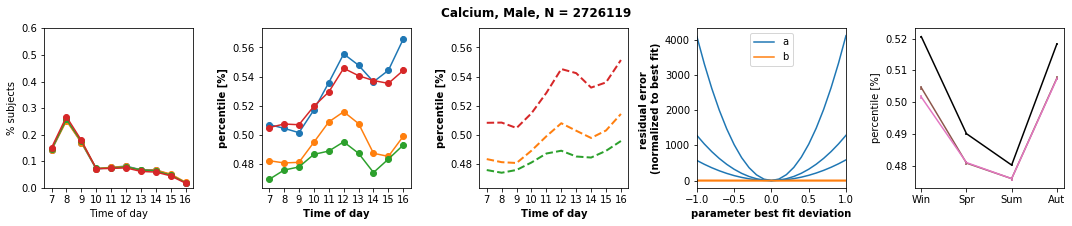

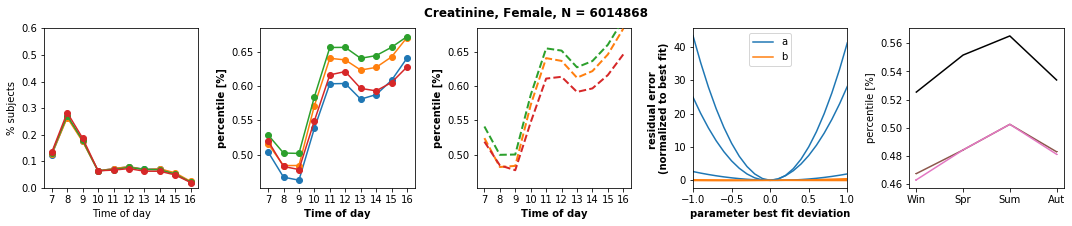

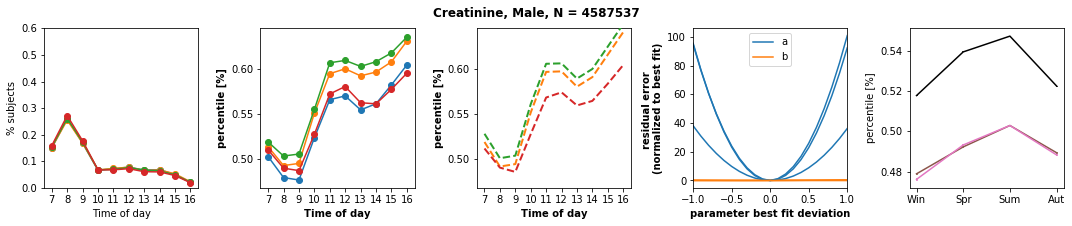

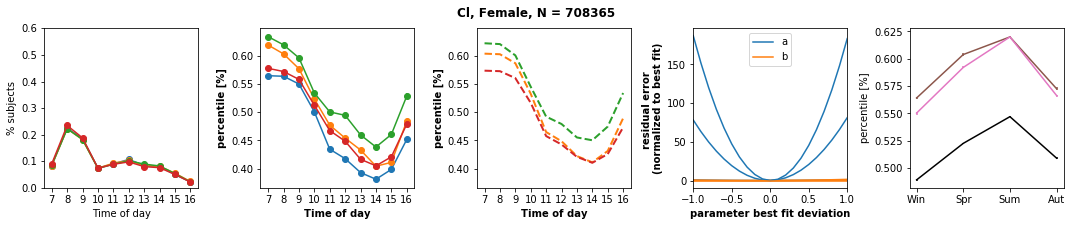

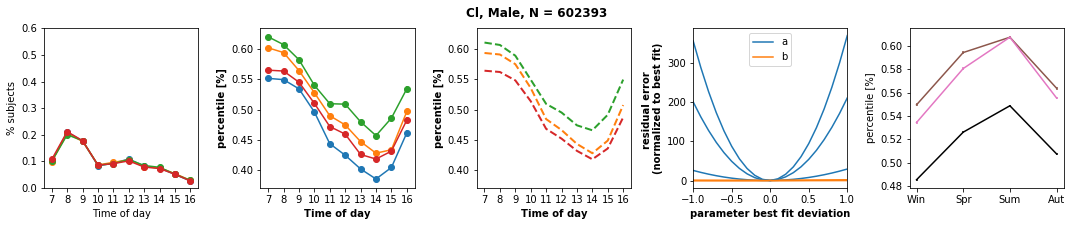

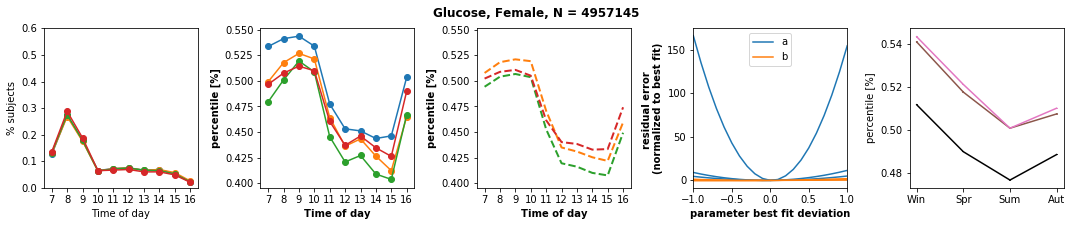

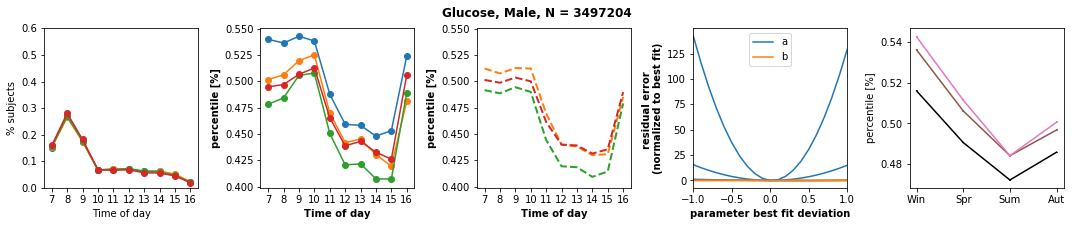

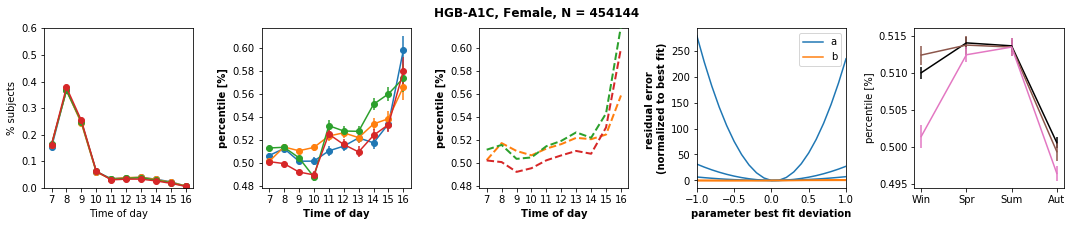

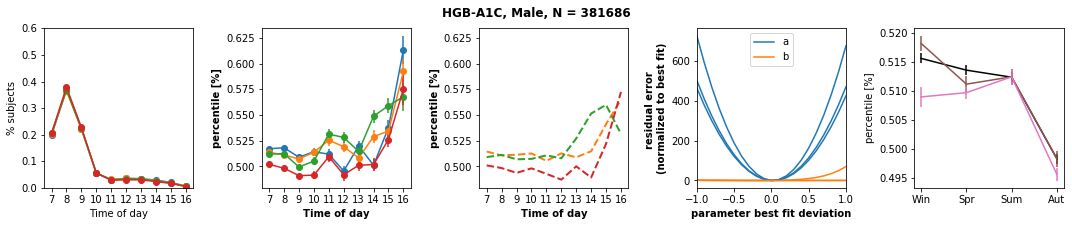

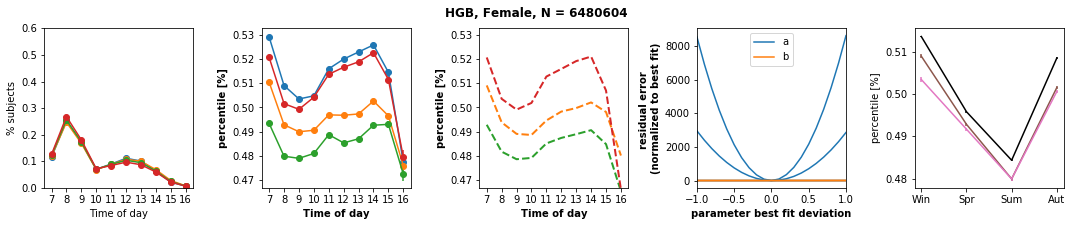

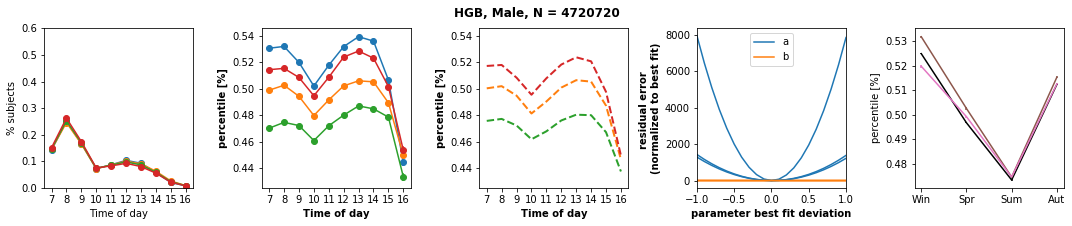

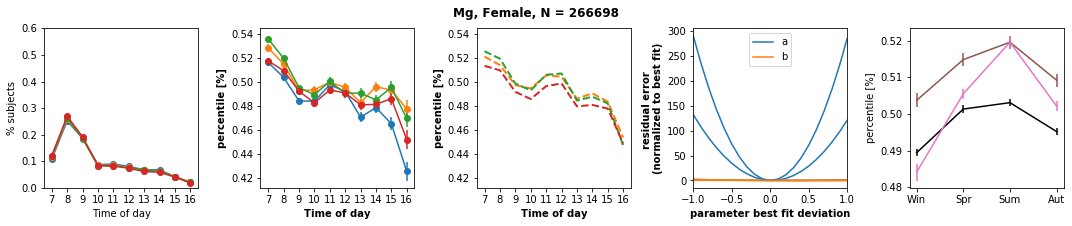

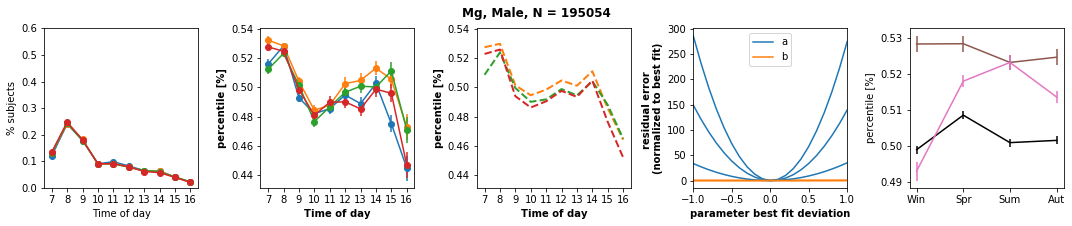

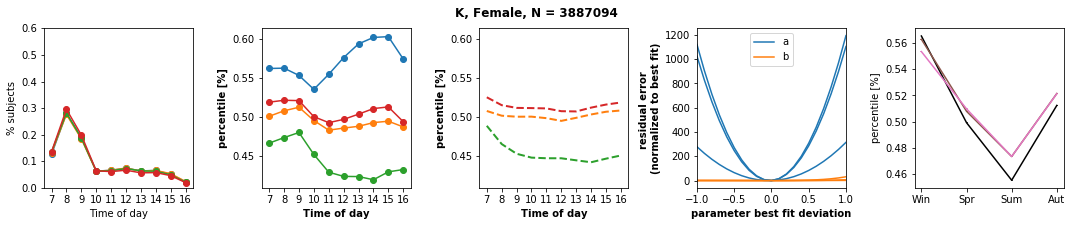

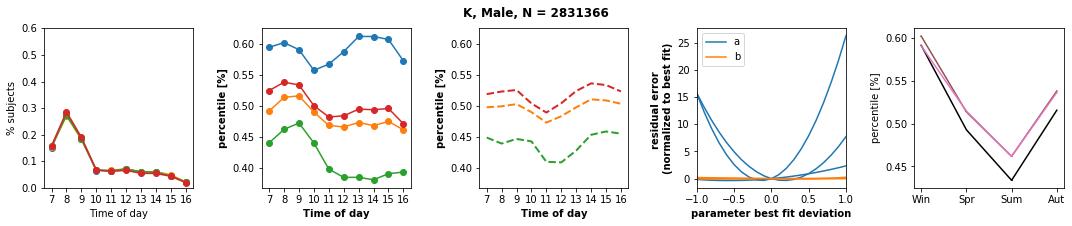

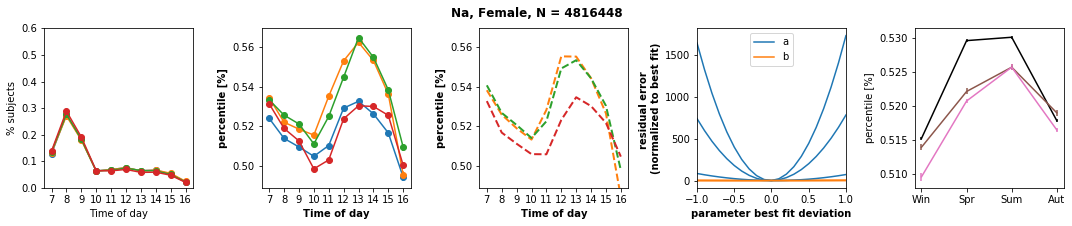

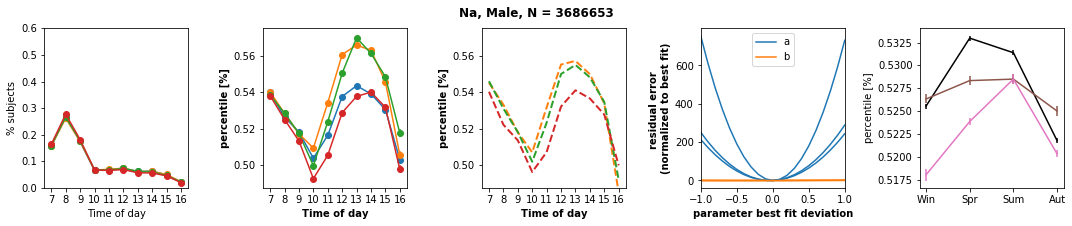

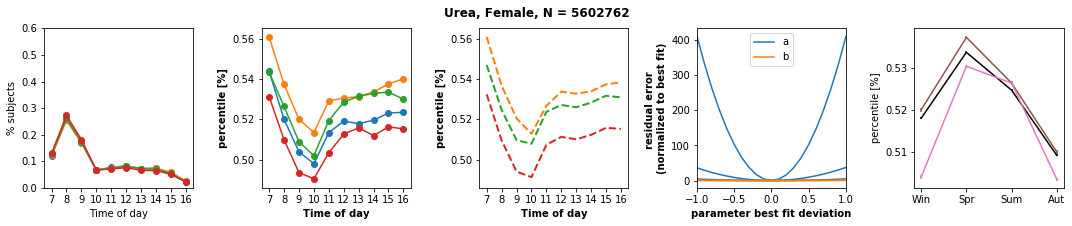

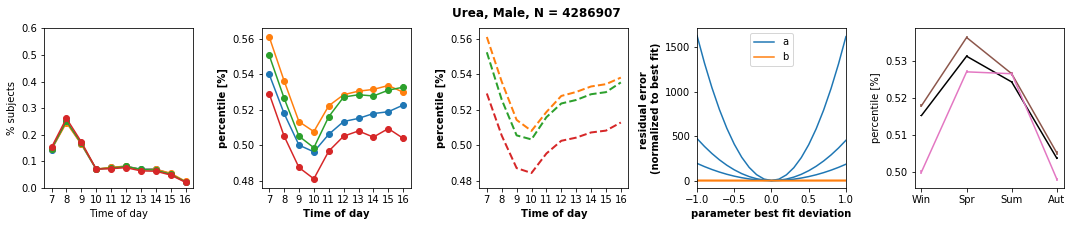

In [9]:
corr_summeries = []
corr1,df1 = plot_circadian_seasonality(pituitary_hormone_dic)
corr2,df2 = plot_circadian_seasonality(effector_hormone_dic)
corr3,df3 = plot_circadian_seasonality(residual_hormone_dic)
corr4,df4 = plot_circadian_seasonality(chem_dic)

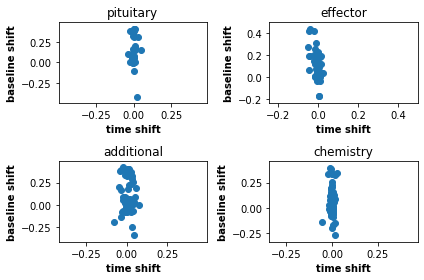

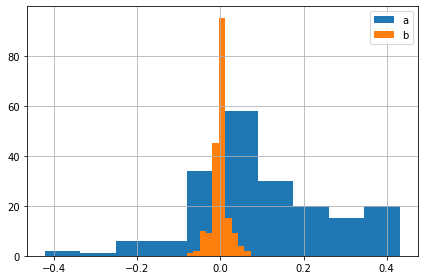

In [10]:
[corr_summeries.append(corr) for corr in [corr1,corr2,corr3,corr4]]
for i,df in enumerate([df1,df2,df3,df4]):
    ax = plt.subplot(2,2,i+1)
    ax.scatter(df.b,df.a)
    ax.set_xlim(ax.get_ylim())
    ax.set_xlabel('time shift',fontweight='bold')
    ax.set_ylabel('baseline shift',fontweight='bold')
    ax.set_title(['pituitary','effector','additional','chemistry'][i])
plt.tight_layout()
plt.show()

df = pd.concat([df1,df2,df3,df4])
ax = plt.subplot(111)
df.a.hist(ax = ax)
df.b.hist(ax = ax)
plt.legend(['a','b'])
plt.tight_layout()

In [11]:
def plot_precent_morning_tests(hormone_dict,ax,title=''):
    dtype = 'quantile'
    res = []
    for h,hormone in enumerate(hormone_dict.keys()):

        file    = '../data/Clalit_seasonality_Nov19/clock.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_80.csv'
        df = pd.read_csv(file)
        df['hour'] = df['hour']+12
        df.loc[df['hour']>24,['hour']] = df.loc[df['hour']>24,['hour']] - 24

        df = df.loc[df['hour']>6]
        df = df.loc[df['hour']<17]

        df_clean = df.loc[df['n']>20].copy()
        df_clean = df_clean.loc[df_clean['type']=='both'].copy()

        ntot = []
        for hour in np.arange(7,17):
            ntot.append(sum(df_clean.loc[df_clean['hour'] == hour]['n']))

        to10 = np.sum(ntot[0:4])/sum(ntot) # 7 to 10
        to12 = np.sum(ntot[0:6])/sum(ntot) # 7 to 12
        res.append([h,to10*100,to12*100])
    res= np.array(res) 

    sorted_i            = np.argsort(res[:,2])[::-1]
    sorted_hormone_list = [list(hormone_dict.values())[i] for i in sorted_i]
    locs = np.arange(0,len(res))
    ax.bar(locs*2,res[sorted_i,2],color =def_color[0])
    ax.bar(locs*2+1,res[sorted_i,1],color =def_color[1])
    ax.set_xticks(np.arange(0,len(res)*2,2)+0.5)
    ax.set_xticklabels(sorted_hormone_list, rotation=90,fontsize=10,fontweight='bold')
    ax.set_ylabel('%Tests',fontsize=12,fontweight='bold')
    ax.legend(['between 7-12','between 7-10'])
    ax.set_ylim([0,100])
    ax.set_title(title,fontweight='bold')

In [18]:
def plot_median_test_time(hormone_dict,ax,title=''):

    dtype = 'quantile'
    res = []
    for h,hormone in enumerate(hormone_dict.keys()):

        file    = '../data/Clalit_seasonality_Nov19/clock.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_80.csv'
        df = pd.read_csv(file)
        df['hour'] = df['hour']+12
        df.loc[df['hour']>24,['hour']] = df.loc[df['hour']>24,['hour']] - 24

        df = df.loc[df['hour']>6]
        df = df.loc[df['hour']<17]

        df_clean = df.loc[df['n']>20].copy()
        df_clean = df_clean.loc[df_clean['type']=='both'].copy()

        seas_mean_time = np.zeros(4)
        seas_std_time  = np.zeros(4)
        for i,seas in enumerate(['winter','spring','summer','fall']):
            sdf = df_clean.loc[df_clean['season'] == seas]

            ntot = [sum(sdf.loc[sdf['hour'] == hour]['n']) for hour in np.arange(7,17)]
            ncum = np.cumsum(ntot)/np.max(np.cumsum(ntot))
            intn = interp1d(np.arange(7,17),ncum,kind='cubic')
            intn2 = lambda x: intn(x) - 0.5
            root  = optimize.newton(intn2, 8)
            seas_mean_time[i] = root# np.sum(sdf['hour']*sdf['n']/np.sum(sdf['n']))
            seas_std_time[i]  = np.sqrt(np.sum((sdf['hour']-seas_mean_time[i])**2/sdf['n']))
        res.append([seas_mean_time,seas_std_time])
    res = np.array(res)

    sorted_i            = np.argsort([res[i,0,:].mean() for i in range(len(res))])[::-1]
    sorted_hormone_list = [list(hormone_dict.values())[i] for i in sorted_i]
    locs = np.arange(0,len(res))

    ax.errorbar(locs*4  ,res[sorted_i,0,0],res[sorted_i,1,0],fmt = 'o',c=matplotlib.cm.get_cmap('Set1')(2/10))
    ax.errorbar(locs*4+1,res[sorted_i,0,1],res[sorted_i,1,1],fmt = 'o',c=matplotlib.cm.get_cmap('Set1')(3/10))
    ax.errorbar(locs*4+2,res[sorted_i,0,2],res[sorted_i,1,2],fmt = 'o',c=matplotlib.cm.get_cmap('Set1')(1/10))
    ax.errorbar(locs*4+3,res[sorted_i,0,3],res[sorted_i,1,3],fmt = 'o',c=matplotlib.cm.get_cmap('Set1')(5/10))
    ax.set_xticks(np.arange(0,len(res)*4+1,4)-0.5)
    ax.grid(axis='x')
    ax.set_xticklabels([])
    ax.set_xticks(np.arange(0,len(res)*4,4)+1.5,minor=True)
    ax.set_xticklabels(sorted_hormone_list, rotation=90,fontsize=10,fontweight='bold',minor=True)
    # ax.set_xlim([-1.5,52.5])
    ax.set_ylim([6,12])

    ax.set_ylabel('Median test time',fontsize=12,fontweight='bold')
    ax.set_title(title)
    # ax.legend(['winter','spring','summer','fall'])


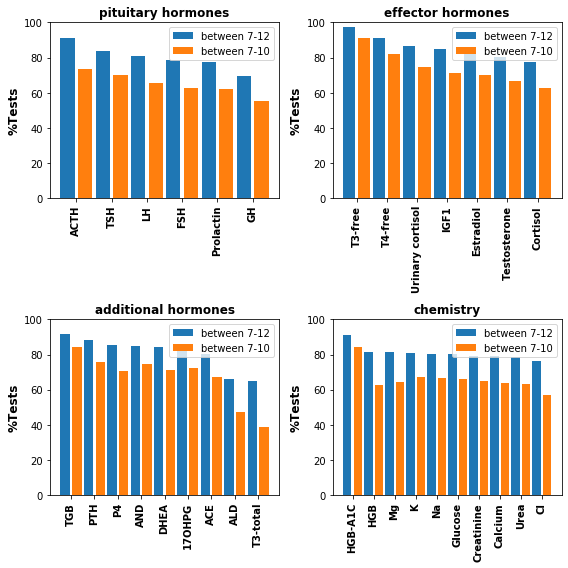

In [12]:
plt.figure(figsize=(8,8))
plot_precent_morning_tests(pituitary_hormone_dic,plt.subplot(2,2,1),title='pituitary hormones')
plot_precent_morning_tests(effector_hormone_dic,plt.subplot(2,2,2),title='effector hormones')
plot_precent_morning_tests(residual_hormone_dic,plt.subplot(2,2,3),title='additional hormones')
plot_precent_morning_tests(chem_dic,plt.subplot(2,2,4),title='chemistry')
plt.tight_layout()

In [13]:
plt.figure(figsize=(8,8))
plot_median_test_time(pituitary_hormone_dic,plt.subplot(2,2,1),title='pituitary hormones')
plot_median_test_time(effector_hormone_dic,plt.subplot(2,2,2),title='effector hormones')
plot_median_test_time(residual_hormone_dic,plt.subplot(2,2,3),title='additional hormones')
plot_median_test_time(chem_dic,plt.subplot(2,2,4),title='chemistry')
plt.tight_layout()

NameError: name 'plot_median_test_time' is not defined

<Figure size 576x576 with 0 Axes>